# Brain Tumor Detection with Syft & SyMPC
Oleksandr Lytvyn
dataset link: [kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

## Data Scientist
#### TASKS
1. Create model
2. Train model on sample data
3. Create request to access encrypted data from DOs
4. Make prediction on encrypted data
5. Share prediction with corresponding DOs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
import os

from transformed_dataset import TransformedImageDataset

device = torch.device('cpu')
torch.manual_seed(1)

In [3]:
dir_path = '../../data/prepared_brain_tumor_imgs/ds'
ds_test_data = TransformedImageDataset(images_path=dir_path + '/test/imgs',
                                       labels_path=dir_path + '/test/labels')
ds_train_data = TransformedImageDataset(images_path=dir_path + '/train/imgs',
                                        labels_path=dir_path + '/train/labels')

print(f"test dataset {len(ds_test_data)}")
print(f"train dataset {len(ds_train_data)}")

test dataset 84
train dataset 1013


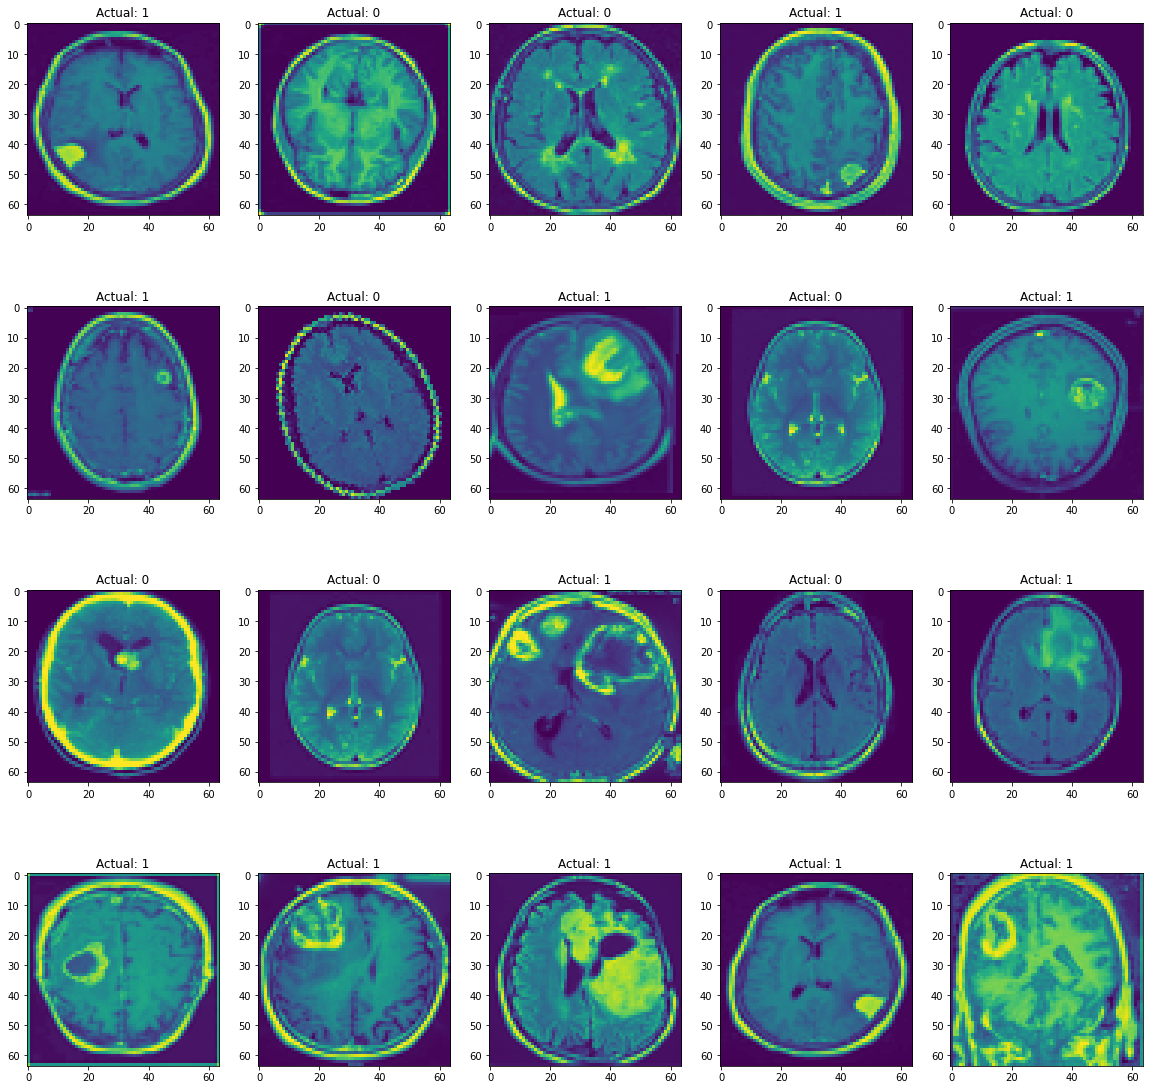

In [3]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = ds_test_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(transforms.ToPILImage()(ds_test_data[i][0]))
    plt.title(f'Actual: {target}')
plt.show()

In [5]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)
        return x
model = BrainTumorModel(torch_ref=torch)
print(model)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 2500

In [20]:
def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss/number_of_imags, accuracy/number_of_imags

def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
        #             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

Epochs: 0 Loss:  0.1879, Accuracy:  0.8500
Epochs: 10 Loss:  0.0927, Accuracy:  0.8458
Epochs: 20 Loss:  0.0887, Accuracy:  0.8458
Epochs: 30 Loss:  0.1515, Accuracy:  0.8250
Epochs: 40 Loss:  0.1159, Accuracy:  0.8354
Epochs: 50 Loss:  0.1503, Accuracy:  0.8250
Epochs: 60 Loss:  0.1479, Accuracy:  0.8250
Epochs: 70 Loss:  0.1553, Accuracy:  0.8146
Epochs: 80 Loss:  0.1143, Accuracy:  0.8604
Epochs: 90 Loss:  0.0919, Accuracy:  0.8250
Epochs: 100 Loss:  0.1482, Accuracy:  0.8354
Epochs: 110 Loss:  0.1250, Accuracy:  0.8354
Epochs: 120 Loss:  0.0774, Accuracy:  0.8250
Epochs: 130 Loss:  0.2322, Accuracy:  0.8250
Epochs: 140 Loss:  0.1429, Accuracy:  0.8458
Epochs: 150 Loss:  0.0612, Accuracy:  0.8250
Epochs: 160 Loss:  0.0881, Accuracy:  0.8250
Epochs: 170 Loss:  0.0916, Accuracy:  0.8396
Epochs: 180 Loss:  0.0596, Accuracy:  0.8250
Epochs: 190 Loss:  0.2112, Accuracy:  0.8458
Epochs: 200 Loss:  0.1412, Accuracy:  0.8354
Epochs: 210 Loss:  0.1051, Accuracy:  0.8354
Epochs: 220 Loss:  0.

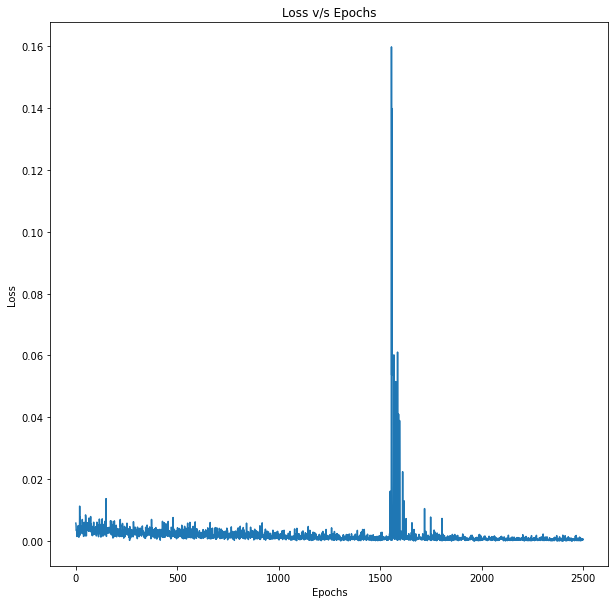

In [21]:
loss_list_dumb = train(model, ds_train_data, ds_test_data, num_epochs=num_epochs)
loss_list = [loss_item.detach() for loss_item in loss_list_dumb]

fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [22]:
eval_loader = DataLoader(ds_test_data, batch_size=1, shuffle=True)
loss , acc = test(model=model, test_loader=eval_loader, loss_fn=loss_fn)
print(f'Test Accuracy: {loss:.2f} \n'
      f'Test Loss: {acc: .2f}')

Test Accuracy: 0.94 
Test Loss:  0.88


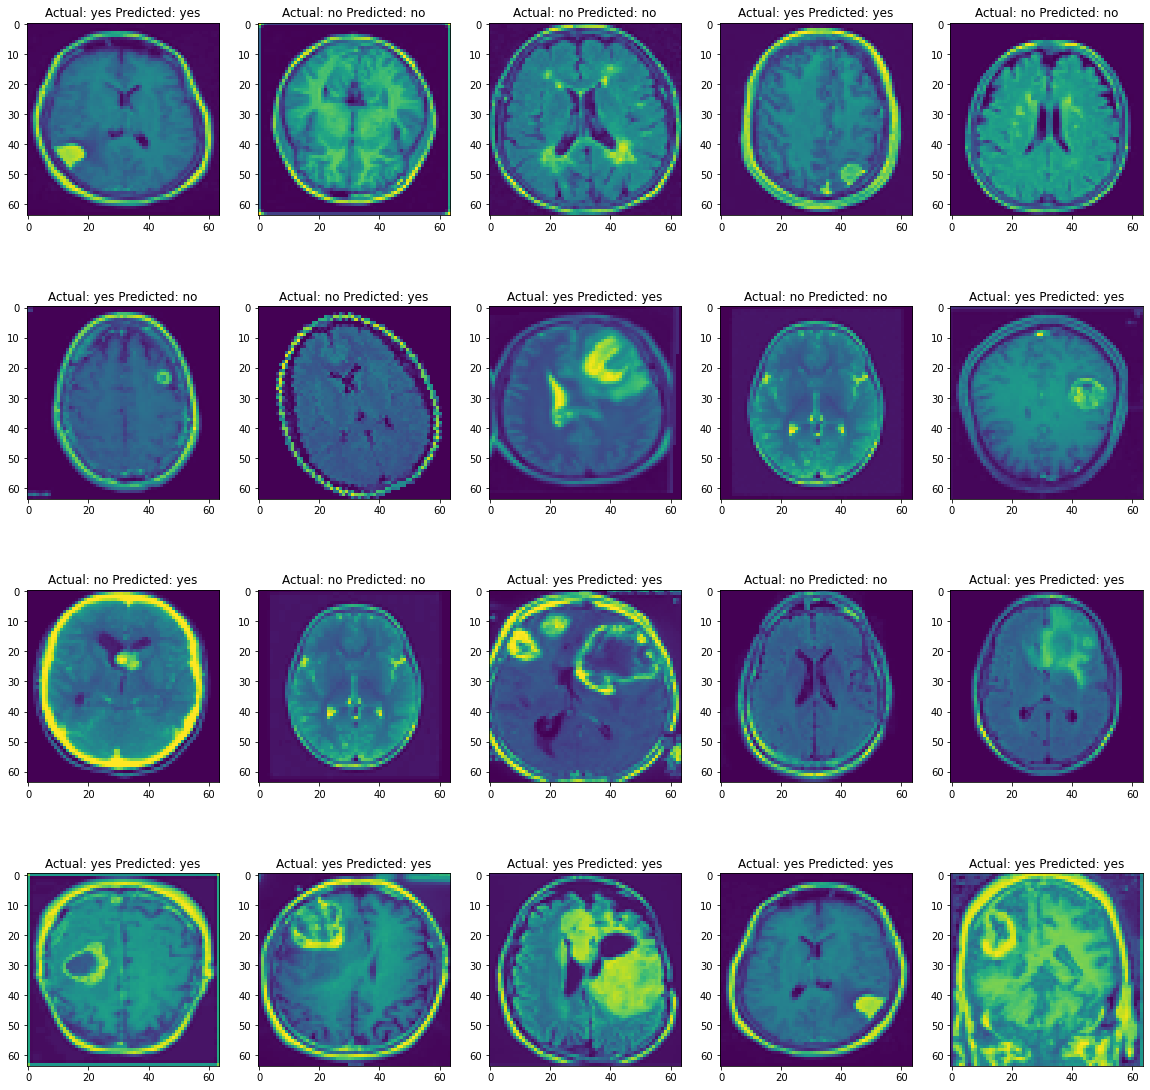

actual accuracy:  0.85


In [23]:
plot_loader = DataLoader(ds_test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [7]:
type(ds_test_data)

transformed_dataset.TransformedImageDataset

In [2]:
ds = sy.login(email="ds@stuba.sk", password="ds_fiit", port=8081)

Connecting to None... done! 	 Logging into tender_thomas... done!


In [3]:
ds.datasets

Idx,Name,Description,Assets,Id
[0],Data from DO1,Brain Tumor MRIs from DO1,"[""Patient 0""] -> Tensor[""Patient 1""] -> Tensor[""Patient 2""] -> Tensor...",337642f9-c536-4fb2-a5f7-ebe81edbfc00


In [4]:
# domain_node.request_privacy_budget(100)
ds.privacy_budget

100.0

In [5]:
data_from_do1 = ds.datasets[0]
data_from_do1

Dataset: Data from DO1
Description: Brain Tumor MRIs from DO1


 assets = my_dataset.assets 

to view receive a dictionary you can parse through using Python
(as opposed to blowing up your notebook with a massive printed table).



Asset Key,Type,Shape
"[""Patient 0""]",Tensor,"(1, 64, 64)"
"[""Patient 1""]",Tensor,"(1, 64, 64)"
"[""Patient 2""]",Tensor,"(1, 64, 64)"
"[""Patient 3""]",Tensor,"(1, 64, 64)"
"[""Patient 4""]",Tensor,"(1, 64, 64)"
"[""Patient 5""]",Tensor,"(1, 64, 64)"
"[""Patient 6""]",Tensor,"(1, 64, 64)"
"[""Patient 7""]",Tensor,"(1, 64, 64)"
"[""Patient 8""]",Tensor,"(1, 64, 64)"
"[""Patient 9""]",Tensor,"(1, 64, 64)"


In [11]:
res_dataset = data_from_do1["Patient 0"]
res_dataset

array([[[ 9, 27, 31, ..., 39, 52, 97],
        [76, 49, 71, ..., 84, 85, 34],
        [41, 16, 86, ..., 12, 29, 78],
        ...,
        [62, 32, 16, ..., 34, 94, 41],
        [43, 60, 21, ...,  1, 35, 72],
        [29, 11, 29, ...,  8, 71, 17]]])

 (The data printed above is synthetic - it's an imitation of the real data.)

In [25]:
res_dataset.get(request_block=True)

[2022-03-08T14:27:29.174565+0100][CRITICAL][logger]][24468] UnknownPrivateException has been triggered.


In [12]:
published_res = res_dataset.publish(sigma=5)

In [13]:
published_res

<FloatPointer -> tender_thomas:88a3d49c4160465da6286bdc15469428>

In [15]:
final_res = published_res.block_with_timeout(60).get()

Exception: Object with id <UID: 88a3d49c4160465da6286bdc15469428> still doesn't exist after 60 second timeout.